In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce

#For interactive plots 
import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data

## initialisation of the dataframe

In [2]:
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')
movies_df['Movie release date corrected'] = pd.to_datetime(movies_df['Movie release date'], format='mixed', yearfirst=True, errors='coerce')
movies_df['release_year'] = movies_df['Movie release date corrected'].dt.year


franchise_df=get_franchise_movies(movies_df)
franchise_data_df = get_franchise_data(franchise_df)
franchise_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   collection_id           1595 non-null   float64       
 1   collection_name         1595 non-null   object        
 2   oldest_release          1588 non-null   datetime64[ns]
 3   newest_release          1588 non-null   datetime64[ns]
 4   movie_count             1595 non-null   int64         
 5   franchise_length        1588 non-null   float64       
 6   franchise_length_years  1588 non-null   float64       
 7   revenue                 255 non-null    float64       
 8   country                 1595 non-null   object        
 9   average_score           1595 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(1), object(2)
memory usage: 124.7+ KB


## First analysis of the different colomn of the dataset

### Year Repartition (from the release date colomn)

In this section, we visualize the distribution of movies over the years to compare whether the CMU dataset and the franchise dataset contain a similar distribution of movies across time.

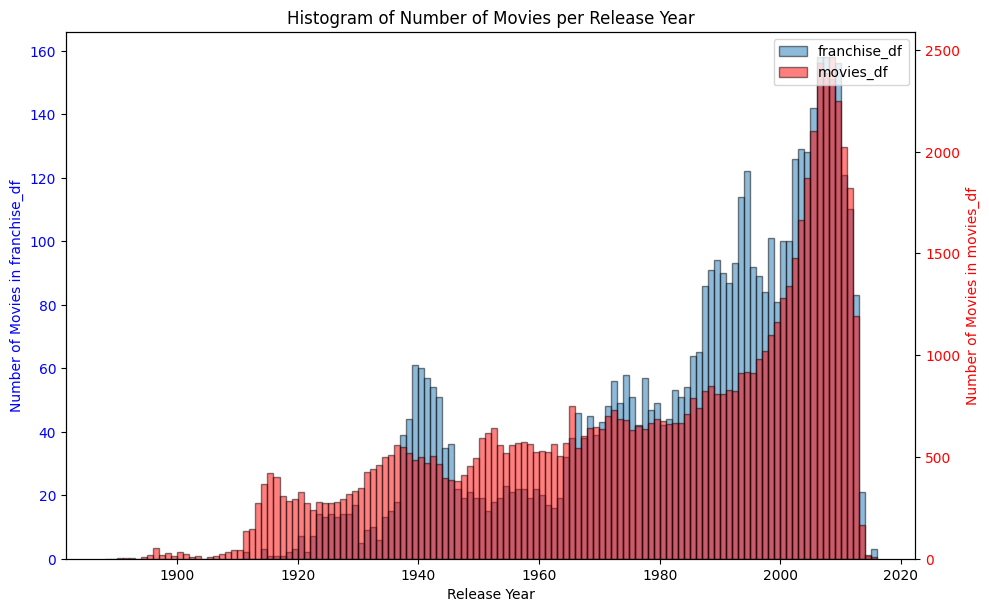

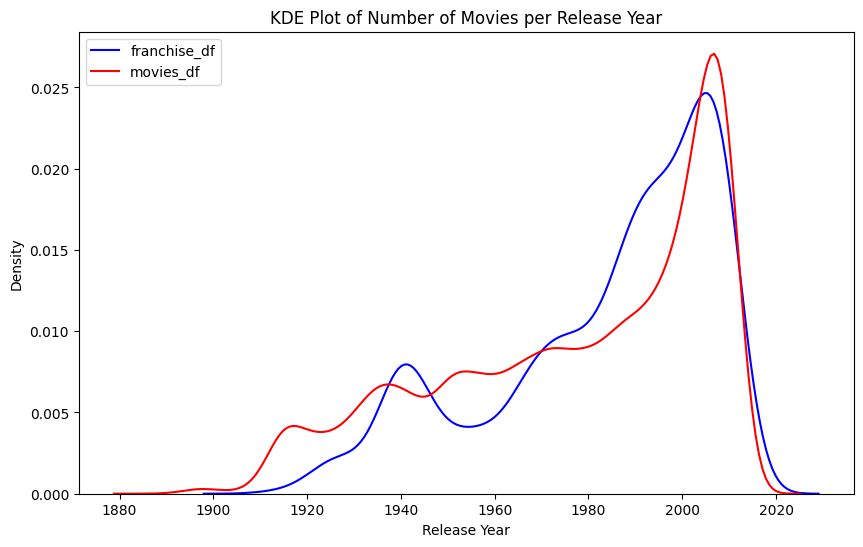

In [3]:

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the histogram for franchise_df
ax1.hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies in franchise_df', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax1.twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax, label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax, label='movies_df', color='red')

# Set labels and title
ax.set_xlabel('Release Year')
ax.set_ylabel('Density')
ax.set_title('KDE Plot of Number of Movies per Release Year')
ax.legend()

plt.show()

In this part, we're visualising in more detail the franchise and collections of movies we're working with

In [4]:
# Ensure the DataFrame is sorted by oldest_release for a neat plot
franchise_data_df = franchise_data_df.sort_values(by='oldest_release').reset_index(drop=True)

# Drop rows where oldest_release or newest_release is NaT (missing dates)
franchise_data_df = franchise_data_df.dropna(subset=['oldest_release', 'newest_release'])

# Define a color mapping for regions or countries
region_color_map = {
    'United States of America': 'blue',
    'Canada': 'green',
    'United Kingdom': 'red',
    'Germany': 'orange',
    'France': 'purple',
    'Japan': 'pink',
    'Australia': 'brown',
    # Add more countries/regions and colors as needed
}

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a bar chart figure
def create_figure(filtered_df):
    # Map each country to a color
    filtered_df['color'] = filtered_df['country'].map(region_color_map).fillna('gray')  # Default to gray if no mapping

    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            x=filtered_df['franchise_length'].apply(lambda x: pd.Timedelta(days=x).days / 365),  # Franchise lengths in years
            y=filtered_df['collection_name'],  # Franchise names
            orientation='h',
            base=filtered_df['oldest_release'].dt.year,  # Base of the bar is the oldest release date
            text=[
                f"Franchise: {row['collection_name']}<br>"
                f"Start Date: {row['oldest_release'].date()}<br>"
                f"End Date: {row['newest_release'].date()}<br>"
                f"Movies: {row['movie_count']}<br>"
                f"Revenue: ${row['revenue'] if not pd.isna(row['revenue']) else 'N/A'}"
                for _, row in filtered_df.iterrows()
            ],  # Tooltip content
            hoverinfo="text",  # Use text for hover information
            marker=dict(color=filtered_df['color']),  # Use the color for the bars
        )
    )

    # Customize layout
    fig.update_layout(
        title="Franchise Durations",
        xaxis_title="Years",
        yaxis_title="Franchise",
        xaxis=dict(showgrid=True),
        yaxis=dict(showticklabels=False, showgrid=False),
        height=800,
        template="plotly_white",
    )
    return fig

# Define the layout of the app
app.layout = html.Div([
    html.H1("Franchise Duration Filter"),
    
    # Dropdown for filtering by revenue
    dcc.Dropdown(
        id='revenue-filter',
        options=[
            {'label': f'Revenue > ${threshold:,.0f}', 'value': threshold}
            for threshold in [0, 100_000_000, 500_000_000, 1_000_000_000]
        ],
        value=0,  # Default value (show all)
        style={'width': '50%'}
    ),
    
    # Graph for the bar chart
    dcc.Graph(id='franchise-graph')
])

# Define the callback to update the figure based on the filter
@app.callback(
    Output('franchise-graph', 'figure'),
    [Input('revenue-filter', 'value')]
)
def update_figure(selected_revenue):
    # Filter the DataFrame based on the selected revenue
    filtered_df = franchise_data_df[franchise_data_df['revenue'] >= selected_revenue]
    
    # Create and return the updated figure
    return create_figure(filtered_df)

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)


In this part we're gonna investigate the distribution of length and of number of movies in the dataset

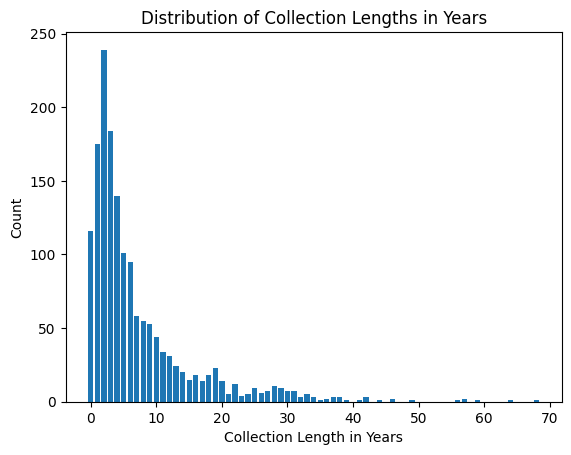

,collection_name,franchise_length_years
12,Dr. Mabuse Collection,42.0
61,Arsène Lupin (Robert Lamoureux) Collection,68.0
64,The Shadow Collection,57.0
93,Fantasia Collection,59.0
110,Bambi Collection,64.0
143,Cinderella Collection,57.0
155,Peter Pan Collection,49.0
162,St. Trinian's Collection,56.0
174,Lady and the Tramp Collection,46.0
213,101 Dalmatians (Animated) Collection,42.0


In [5]:
# Count the number of collection of same length
franchise_data_df_counts = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_counts.columns = ['franchise_length_years', 'count']
# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['franchise_length_years'], franchise_data_df_counts['count'])
ax.set_xlabel('Collection Length in Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Collection Lengths in Years')
plt.show()

# Show the outliers for a length of 40 years and more
outliers = franchise_data_df[franchise_data_df['franchise_length_years'] >= 40]
outliers[['collection_name', 'franchise_length_years']]

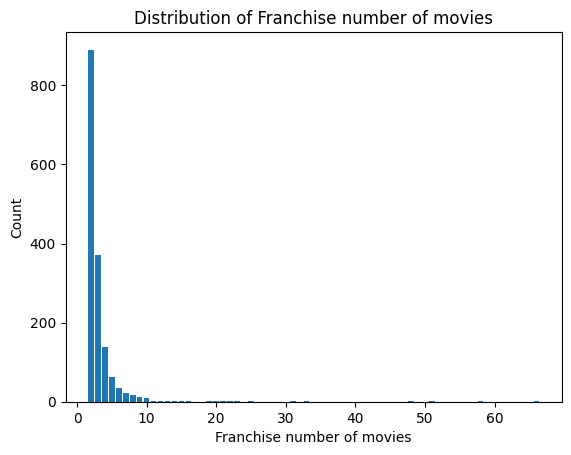

,collection_name,movie_count
13,Our Gang: The Roach/Pathé silents (1922-1928),66
17,Our Gang: The Roach/MGM silents (1927–1929),22
31,Our Gang: The MGM talkies (1929-1938),58
49,The Three Mesquiteers Collection,51
70,Charlie Chan (Sidney Toler) Collection,21
90,East Side Kids Collection,20
124,The Bowery Boys Collection,48
196,Carry On Collection,31
225,James Bond Collection,23
323,Tora-san Series,48


In [6]:
# Count the number of collection with the same number of movies
franchise_data_df_counts = franchise_data_df['movie_count'].value_counts().reset_index()
franchise_data_df_counts.columns = ['movie_count', 'count']
# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['movie_count'], franchise_data_df_counts['count'])
ax.set_xlabel('Franchise number of movies')
ax.set_ylabel('Count')
ax.set_title('Distribution of Franchise number of movies')
plt.show()

# Show the outliers for a number of movies of 20 and more
outliers = franchise_data_df[franchise_data_df['movie_count'] >= 20]
outliers[['collection_name', 'movie_count']]

We see that most of the franchise have 2 movies, which could be sequel of 2 movies but also be an original movie with a remake or an additional movie of a side story, to try to separate them, we try to normalize this length and number of movie distribution

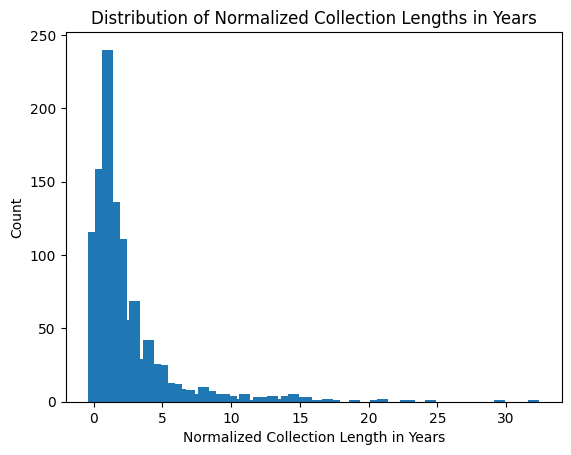

Outliers (Normalized Length >= 15 years):
                                collection_name  franchise_length_normalized
16                        Abel Gance's Napoleon                    16.500000
61   Arsène Lupin (Robert Lamoureux) Collection                    22.666667
86                                Oz Collection                    17.000000
93                          Fantasia Collection                    29.500000
110                            Bambi Collection                    32.000000
143                       Cinderella Collection                    19.000000
155                        Peter Pan Collection                    24.500000
174               Lady and the Tramp Collection                    23.000000
213        101 Dalmatians (Animated) Collection                    21.000000
228                        The Birds Collection                    15.500000
287                        Monster X Collection                    20.500000
292                  The Jungle Bo

In [7]:
# Normalize the length by the number of movies
franchise_data_df['franchise_length_normalized'] = franchise_data_df['franchise_length_years'] / franchise_data_df['movie_count']

# Count the number of collection with the same normalized length
franchise_data_df_counts = franchise_data_df['franchise_length_normalized'].value_counts().reset_index()
franchise_data_df_counts.columns = ['franchise_length_normalized', 'count']

# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['franchise_length_normalized'], franchise_data_df_counts['count'])
ax.set_xlabel('Normalized Collection Length in Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Normalized Collection Lengths in Years')
plt.show()

# Show the outliers for a normalized length of 15 years and more
print("Outliers (Normalized Length >= 15 years):")
print(franchise_data_df[franchise_data_df['franchise_length_normalized'] >= 15][['collection_name', 'franchise_length_normalized']])

# Show the 10 first where the normalized length under 5 years
print("\nFirst 10 (Normalized Length < 5 years):")
print(franchise_data_df[franchise_data_df['franchise_length_normalized'] < 5].head(10)[['collection_name', 'franchise_length_normalized']])

Now show the average vote score per collection for different normalized years values

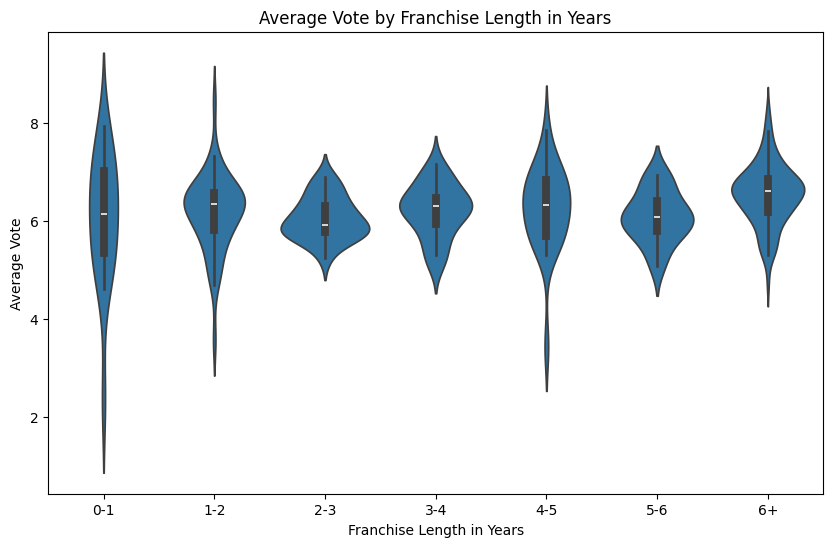

In [ ]:
# violin plot of the average vote by length in years with 8 bashes for 0,1,2,3,4,5,6 and more than 6 years
franchise_data_df['franchise_length_years_binned'] = pd.cut(franchise_data_df['franchise_length_years'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6+'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='franchise_length_years_binned', y='average_score',data=franchise_data_df.dropna(),ax=ax)
ax.set_xlabel('Franchise Length in Years')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by Franchise Length in Years')
plt.show()

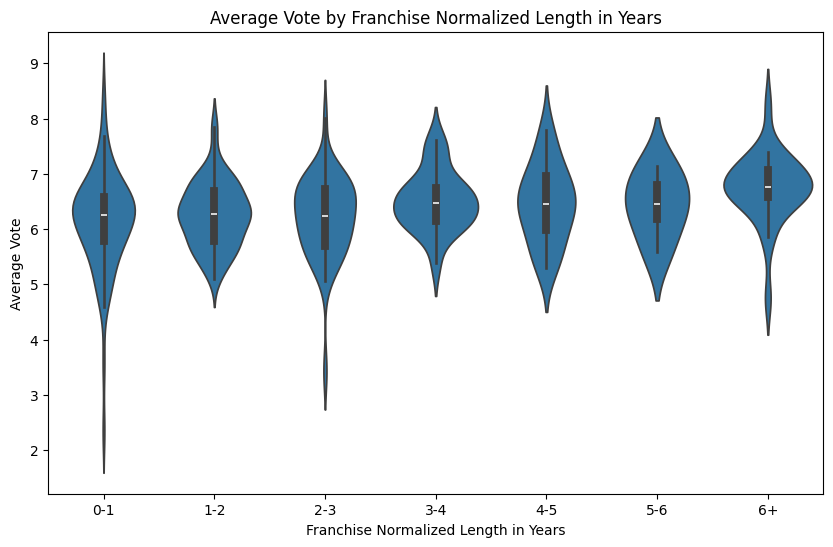

In [19]:
# violin plot of the average vote by length in years with 8 bashes for 0,1,2,3,4,5,6 and more than 6 years
franchise_data_df['franchise_normalized_length_years_binned'] = pd.cut(franchise_data_df['franchise_length_normalized'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6+'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='franchise_normalized_length_years_binned', y='average_score',data=franchise_data_df.dropna(),ax=ax)
ax.set_xlabel('Franchise Normalized Length in Years')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by Franchise Normalized Length in Years')
plt.show()

Now we can also investigate the score for each movie in a collection according to their order of release

In [20]:
# add a collmn with the numerotation of the movies in the collection by release date order
franchise_df['movie_order'] = franchise_df.groupby('collection_name')['Movie release date corrected'].rank(method='first')

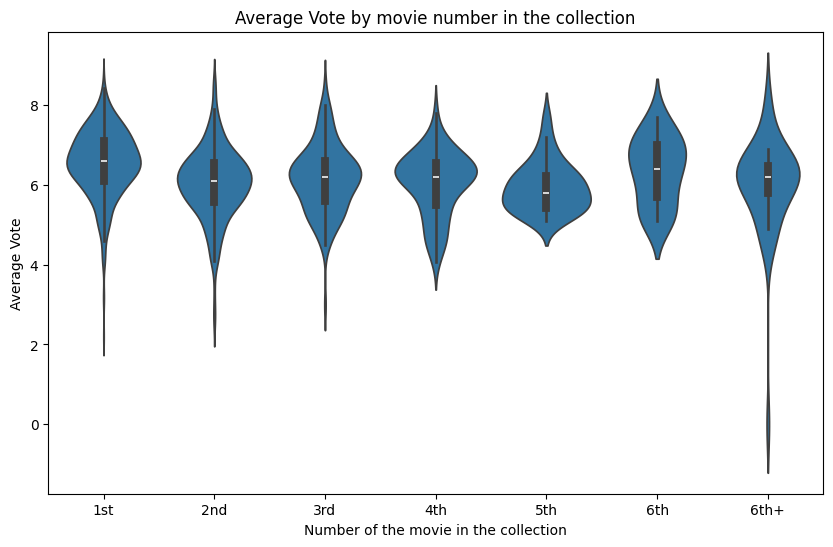

In [22]:
# violin plot of the average vote for the movie order with 8 bashes for 0,1,2,3,4,5,6 and more than 6th movie
franchise_df['movie_order_binned'] = pd.cut(franchise_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='movie_order_binned', y='vote_average',data=franchise_df.dropna(),ax=ax)
ax.set_xlabel('Number of the movie in the collection')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by movie number in the collection')
plt.show()